In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
device = torch.device("xpu")

## MNIST U-Net

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels: int = 1):
        super().__init__()

        self.down1 = ConvBlock(in_channels, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(256 + 128, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_channels, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.down1(x)
        x = self.maxpool(x1)

        x2 = self.down2(x)
        x = self.maxpool(x2)

        x = self.bot1(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        x = self.out(x)

        return x

In [4]:
model = UNet()
x = torch.randn(10, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


In [5]:
def _sinusodial_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    v = torch.zeros(output_dim, device=device)

    i = torch.arange(0, output_dim, device=device)
    div_term = 10000 ** (i / output_dim)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v


def sinusodial_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    batch_size = len(t)
    v = torch.zeros(batch_size, output_dim, device=device)

    for i in range(batch_size):
        v[i] = _sinusodial_pos_encoding(t[i], output_dim, device)

    return v


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # 위치 인코딩 매트릭스 생성
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # 10000^(2i/d_model) 계산
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )

        # 사인/코사인 적용
        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수 인덱스
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수 인덱스

        # 배치 차원 추가하고 등록
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: [seq_len, batch_size, d_model]
        """
        return x + self.pe[: x.size(0), :]

In [6]:
class ConvBlock2(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_dim: int):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_dim, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels),
        )

    def forward(self, x: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        N, C, _, _ = x.shape
        v = self.mlp(v).view(N, C, 1, 1)
        y = self.conv(x + v)
        return y


class UNet2(nn.Module):
    def __init__(self, in_channels: int = 1, time_dim: int = 100):
        super().__init__()

        self.time_dim = time_dim

        self.down1 = ConvBlock2(in_channels, 64, time_dim)
        self.down2 = ConvBlock2(64, 128, time_dim)
        self.bot1 = ConvBlock2(128, 256, time_dim)
        self.up2 = ConvBlock2(256 + 128, 128, time_dim)
        self.up1 = ConvBlock2(128 + 64, 64, time_dim)
        self.out = nn.Conv2d(64, in_channels, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

    def forward(self, x: torch.Tensor, time_steps) -> torch.Tensor:
        v = sinusodial_pos_encoding(time_steps, self.time_dim, device=x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)

        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)

        return x

In [7]:
x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

In [8]:
def reverse(x: torch.Tensor):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    return transforms.ToPILImage()(x)

(64, 64, 3)
torch.Size([3, 64, 64])


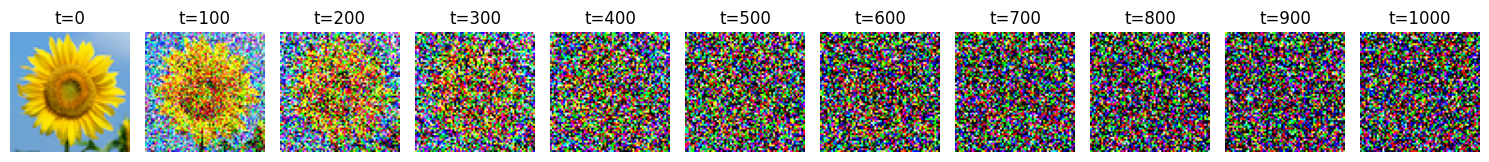

In [9]:
image = plt.imread("./data/flower.png")
print(image.shape)

x = transforms.ToTensor()(image)
print(x.shape)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

imgs.append(reverse(x))

plt.figure(figsize=(15, 5))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(img)
    plt.title(f"t={i * 100}")
    plt.axis("off")

plt.tight_layout()
plt.show()

(64, 64, 3)
torch.Size([3, 64, 64])


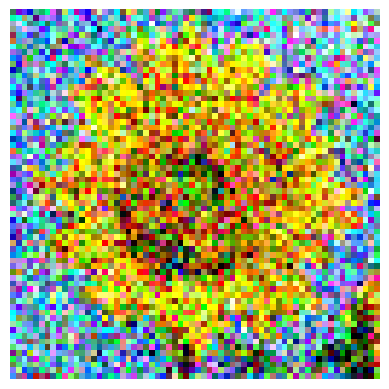

In [10]:
def add_noise(x_0: torch.Tensor, t: int, betas: torch.Tensor):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    bar_alphas = torch.cumprod(alphas, dim=0)

    t_index = t - 1
    bar_alpha = bar_alphas[t_index]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(bar_alpha) * x_0 + torch.sqrt(1 - bar_alpha) * eps

    return x_t


image = plt.imread("./data/flower.png")
print(image.shape)

x = transforms.ToTensor()(image)
print(x.shape)

t = 100
x_t = add_noise(x, t, betas)
img = reverse(x_t)
plt.imshow(img)
plt.axis("off")
plt.show()

# T = 1000
# beta_start = 0.0001
# beta_end = 0.02
# betas = torch.linspace(beta_start, beta_end, T)


In [11]:
class Diffuser:
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        device: torch.device | str = "cpu",
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.bar_alphas = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0: torch.Tensor, t: torch.Tensor):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        bar_alpha = self.bar_alphas[t_index]
        N = bar_alpha.size(0)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(bar_alpha) * x_0 + torch.sqrt(1 - bar_alpha) * noise

        return x_t, noise

    def denoise(self, model: torch.nn.Module, x: torch.Tensor, t: torch.Tensor):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        alpha = self.alphas[t_index]
        bar_alpha = self.bar_alphas[t_index]
        bar_alpha_prev = self.bar_alphas[t_index - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)
        bar_alpha_prev = bar_alpha_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - bar_alpha)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - bar_alpha_prev) / (1 - bar_alpha))

        return mu + std * noise

    def reverse(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        return transforms.ToPILImage()(x)

    def sample(self, model: torch.nn.Module, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.int64)
            x = self.denoise(model, x, t)

        images = [self.reverse(x[i]) for i in range(batch_size)]

        return images

In [12]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3


def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(15, 5))
    for row in range(rows):
        for col in range(cols):
            idx = row * cols + col
            if idx < len(images):
                ax = fig.add_subplot(rows, cols, idx + 1)
                ax.imshow(images[idx], cmap="gray")
                ax.axis("off")
    plt.tight_layout()
    plt.show()


transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST("./data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size, True)

diffuser = Diffuser(
    num_timesteps=num_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    device=device,
)
model = UNet2()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr)

100%|██████████| 1000/1000 [00:23<00:00, 42.06it/s]


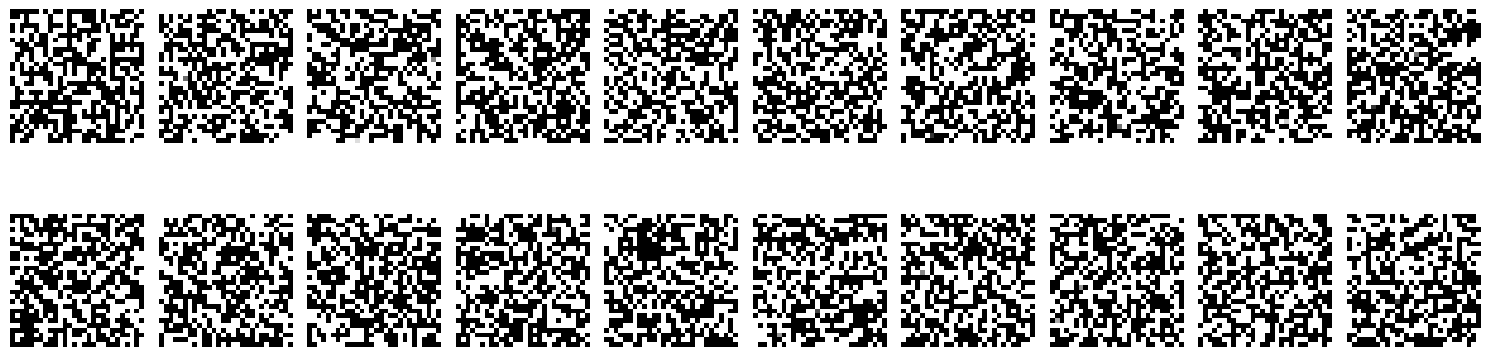

100%|██████████| 469/469 [02:00<00:00,  3.89it/s]


Epoch 1/10, Loss: 0.0450


100%|██████████| 1000/1000 [00:23<00:00, 43.17it/s]


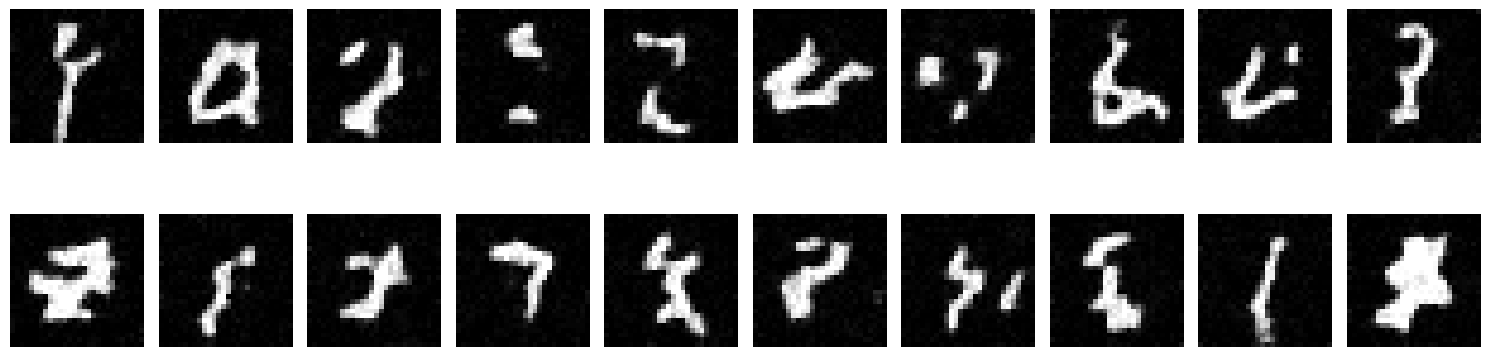

100%|██████████| 469/469 [01:58<00:00,  3.97it/s]


Epoch 2/10, Loss: 0.0262


100%|██████████| 1000/1000 [00:22<00:00, 43.54it/s]


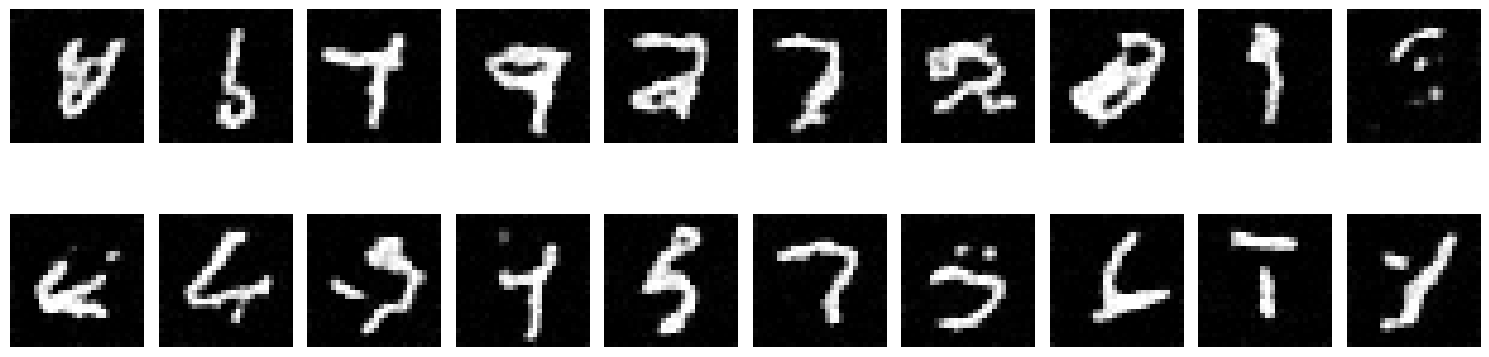

100%|██████████| 469/469 [01:57<00:00,  4.00it/s]


Epoch 3/10, Loss: 0.0229


100%|██████████| 1000/1000 [00:24<00:00, 41.64it/s]


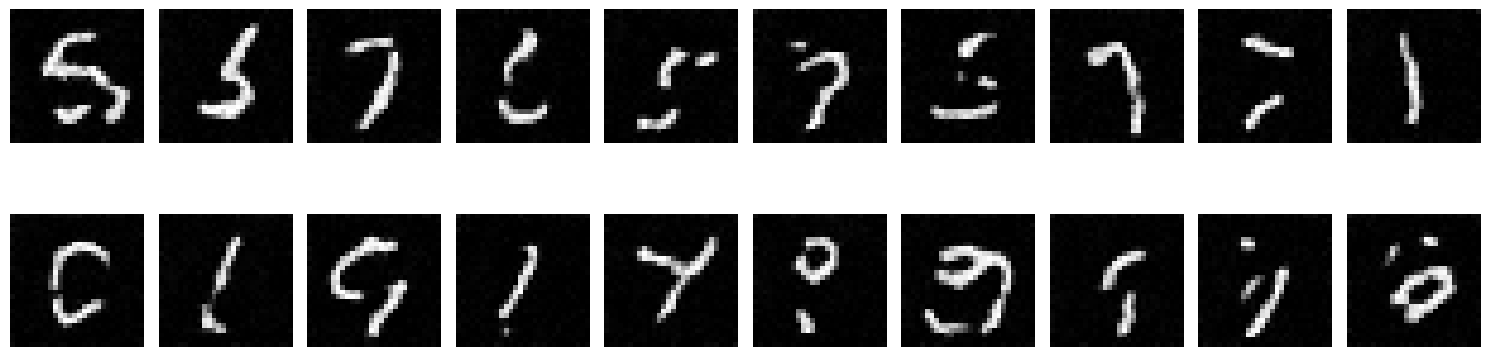

100%|██████████| 469/469 [01:56<00:00,  4.03it/s]


Epoch 4/10, Loss: 0.0231


100%|██████████| 1000/1000 [00:24<00:00, 40.89it/s]


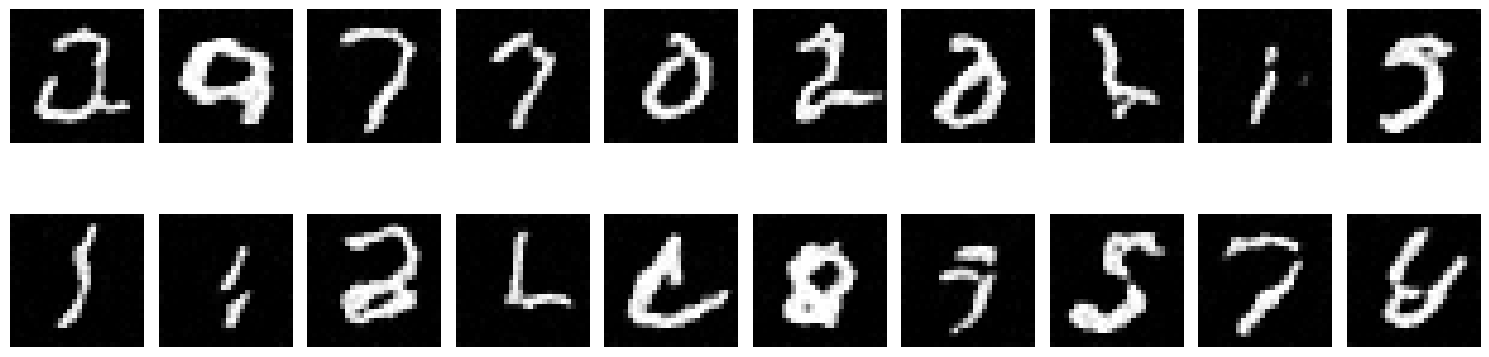

100%|██████████| 469/469 [02:12<00:00,  3.53it/s]


Epoch 5/10, Loss: 0.0214


100%|██████████| 1000/1000 [00:34<00:00, 28.68it/s]


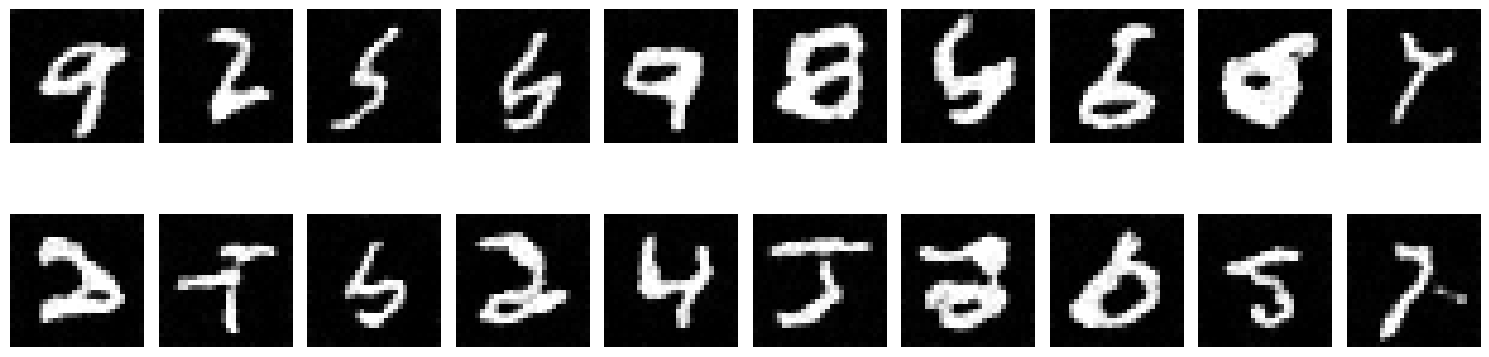

100%|██████████| 469/469 [02:14<00:00,  3.47it/s]


Epoch 6/10, Loss: 0.0200


100%|██████████| 1000/1000 [00:33<00:00, 29.45it/s]


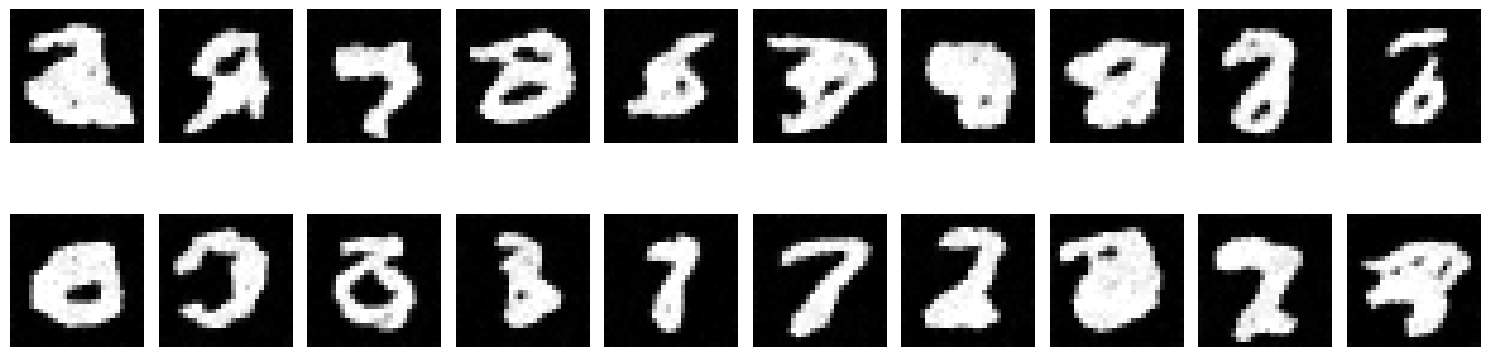

100%|██████████| 469/469 [02:14<00:00,  3.50it/s]


Epoch 7/10, Loss: 0.0193


100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s]


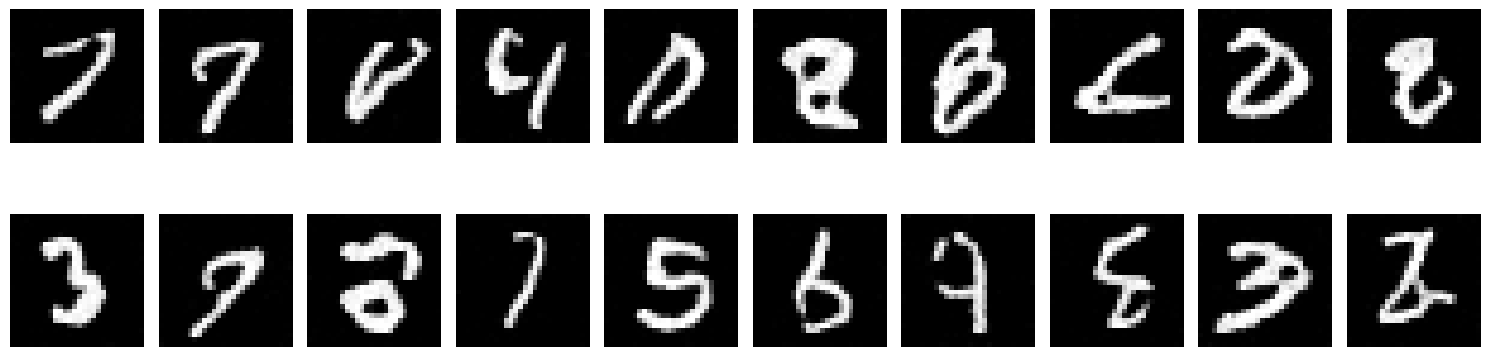

100%|██████████| 469/469 [02:09<00:00,  3.61it/s]


Epoch 8/10, Loss: 0.0187


100%|██████████| 1000/1000 [00:24<00:00, 40.38it/s]


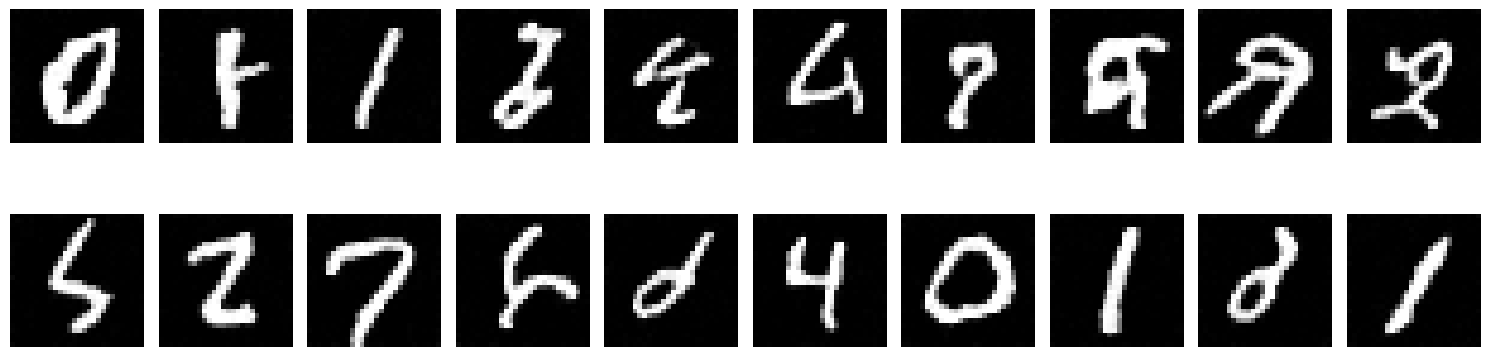

100%|██████████| 469/469 [02:03<00:00,  3.79it/s]


Epoch 9/10, Loss: 0.0186


100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


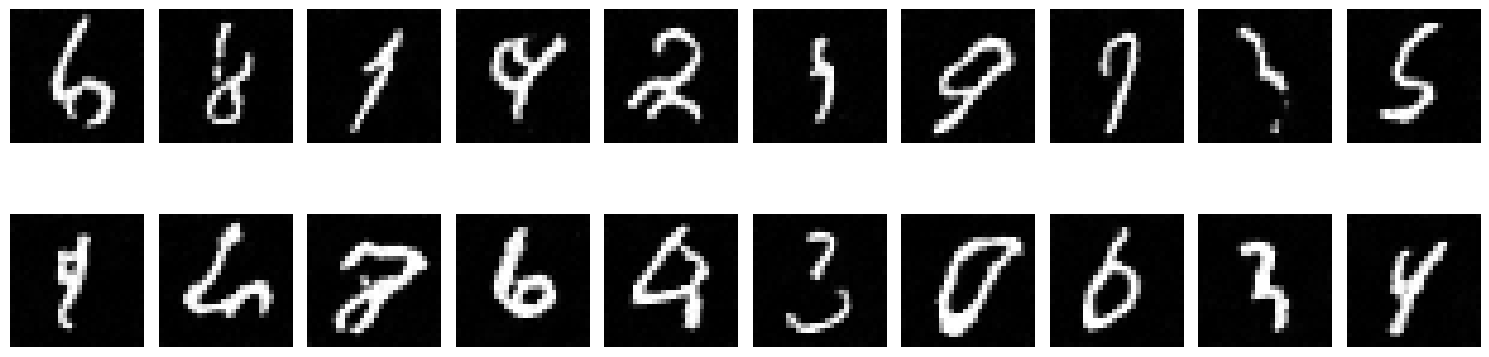

100%|██████████| 469/469 [02:18<00:00,  3.39it/s]

Epoch 10/10, Loss: 0.0182


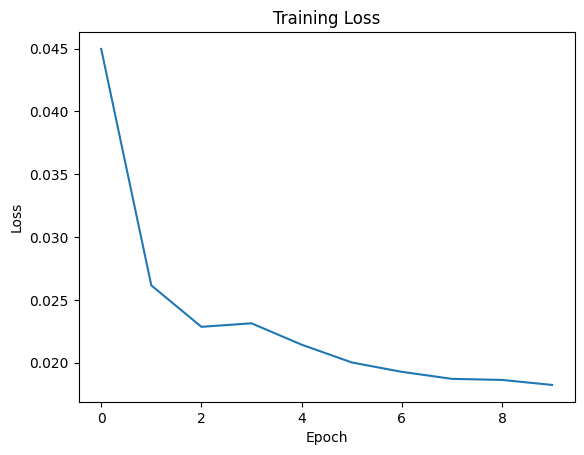

100%|██████████| 1000/1000 [00:35<00:00, 28.39it/s]


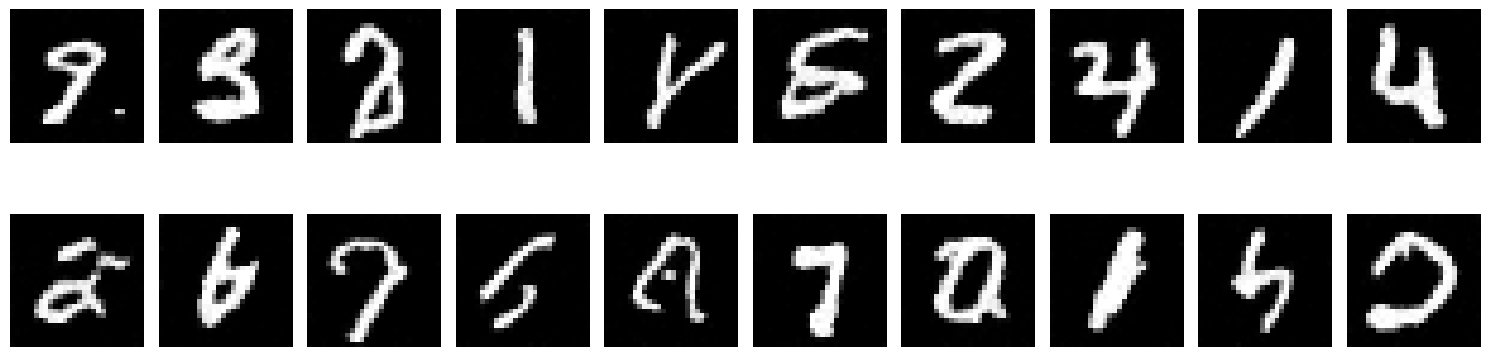

In [13]:
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    count = 0

    images = diffuser.sample(model)
    show_images(images)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(
            1, num_timesteps + 1, (len(x),), device=device, dtype=torch.int64
        )

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        count += 1

    loss_avg = loss_sum / count
    losses.append(loss_avg)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_avg:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

images = diffuser.sample(model)
show_images(images)

In [14]:
from safetensors.torch import save_file

save_file(
    model.state_dict(), "models/diffuser_unet.safetensors", metadata={"format": "torch"}
)
print("Model weights saved to models/diffuser_unet.safetensors")

Model weights saved to models/diffuser_unet.safetensors
